<a href="https://colab.research.google.com/github/Micaiah4data/Amazon_Dashboard/blob/main/Test_VGG16_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from google.colab import files
from google.colab import drive
import glob
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
!pip install shap
import shap
from skimage.segmentation import slic
from matplotlib.colors import LinearSegmentedColormap
import warnings

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataframe = pd.read_csv('benign-and-malignant-images-labels-final.csv')
directory = '/content/Benign-and-Malignant-Images'

In [5]:
image_list = []
for i in range(1, 282):
  filename = directory + "/" + str(i) + ".jpg"
  image = load_img(filename, target_size = (224, 224))
  image_list.append(np.array(image))

In [6]:
for i in range(281):
    if dataframe['benign_malignant'][i] == "malignant":
        dataframe['benign_malignant'][i] = 1
    elif dataframe['benign_malignant'][i] == "benign":
        dataframe['benign_malignant'][i] = 0
    else:
        dataframe['benign_malignant'][i] = -1

<ipython-input-6-1b4dba39b1f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['benign_malignant'][i] = 1
<ipython-input-6-1b4dba39b1f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['benign_malignant'][i] = 1
<ipython-input-6-1b4dba39b1f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['benign_malignant'][i] = 1
<ipython-input-6-1b4dba39b1f7>:3: SettingWithCopyWarning: 
A value is trying to be set o

In [7]:
dataframe['images'] = image_list

In [8]:
dataframeShuffled = shuffle(dataframe)

In [9]:
train_ds, test_ds, train_labels, test_labels = train_test_split(dataframeShuffled['images'].tolist(), dataframeShuffled['benign_malignant'], test_size =  0.33, random_state = 1)
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [10]:
train_ds = tf.image.resize(train_ds, (224, 224))
test_ds = tf.image.resize(test_ds, (224, 224))

In [11]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False

train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

80134624/80134624 [==============================] - 1s 0us/step


In [12]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=15,  restore_best_weights=True)

results = model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
5/5 [==============================] - 17s 2s/step - loss: 4.6600 - accuracy: 0.6600 - val_loss: 1.5556e-05 - val_accuracy: 1.0000
Epoch 2/50
5/5 [==============================] - 1s 220ms/step - loss: 0.2159 - accuracy: 0.9800 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
5/5 [==============================] - 1s 220ms/step - loss: 4.2040e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
5/5 [==============================] - 1s 221ms/step - loss: 1.7664e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
5/5 [==============================] - 1s 220ms/step - loss: 9.7132e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
5/5 [==============================] - 1s 196ms/step - loss: 1.0283e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
5/5 [==============================] - 1s 195ms/step - loss: 2.6702e-07 - accuracy: 1.0000 - val_loss: 0.0000e+

(-0.5, 223.5, 223.5, -0.5)

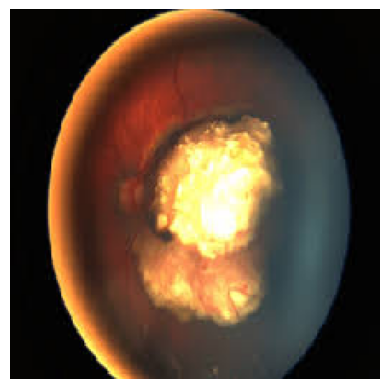

In [19]:
file = directory + "/" + str(102) + ".jpg"
explain_this_image = load_img(file, target_size = (224, 224))
explain_this_image_before = np.array(explain_this_image)
plt.imshow(explain_this_image)
plt.axis('off')

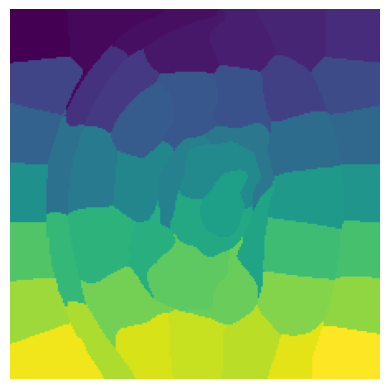

In [20]:
segments_slic = slic(explain_this_image, n_segments=50, compactness=30, sigma=3)
plt.imshow(segments_slic);
plt.axis('off');

In [21]:
def mask_image(zs, segmentation, explain_this_image, background=None):
    if background is None:
        background = explain_this_image.mean((0,1))
    out = np.zeros((zs.shape[0], explain_this_image.shape[0], explain_this_image.shape[1], explain_this_image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):

    return model.predict(preprocess_input(mask_image(z, segments_slic, explain_this_image_before, 255)))

In [22]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

1/1 [==============================] - 1s 1s/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 7s 220ms/step


1/1 [==============================] - 0s 19ms/step


<Axes: title={'center': 'Top 10 Predictions'}>

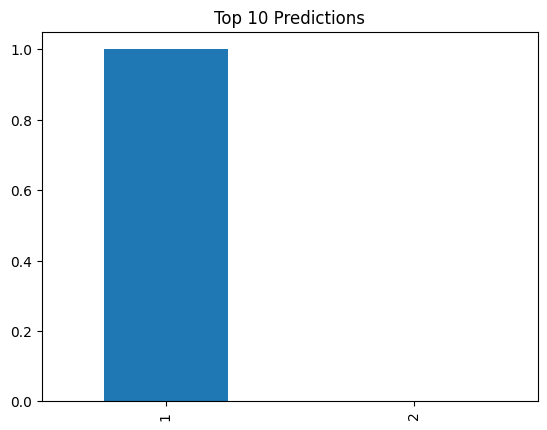

In [23]:
preds = model.predict(preprocess_input(np.expand_dims(explain_this_image_before.copy(), axis=0)))
# feature_names
top_preds = np.argsort(-preds)
inds = top_preds[0]
#top_10_pred=pd.Series(data={feature_names[str(inds[i])][1]:preds[0, inds[i]] for i in range(10)})
top_10_pred=pd.Series(data={str(inds[i]):preds[0, inds[i]] for i in range(2)})
top_10_pred.plot(kind='bar', title='Top 10 Predictions')

Shape of shap_values[inds[i]]: (5,)


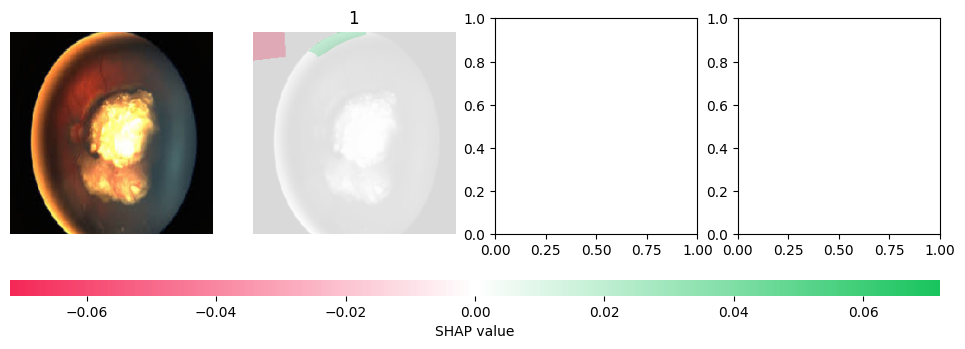

In [27]:
# make a color map
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))

cm = LinearSegmentedColormap.from_list("shap", colors)
# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(explain_this_image)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(min(2, shap_values.shape[0])):  # Iterate up to the length of shap_values
    print("Shape of shap_values[inds[i]]:", shap_values[0][inds[i]].shape)  # Print the shape, accessing the second dimension
    m = fill_segmentation(shap_values[0][inds[i]], segments_slic)  # Access the second dimension
#    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].set_title(str(inds[i]))
    axes[i+1].imshow(explain_this_image.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

In [28]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=cba4cd419b414a990a75659717ee03241277ee4636d671db0e1bd915dfe01366
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [29]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [30]:
explanation = explainer.explain_instance(explain_this_image_before.astype('double'), model.predict,
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


(-0.5, 223.5, 223.5, -0.5)

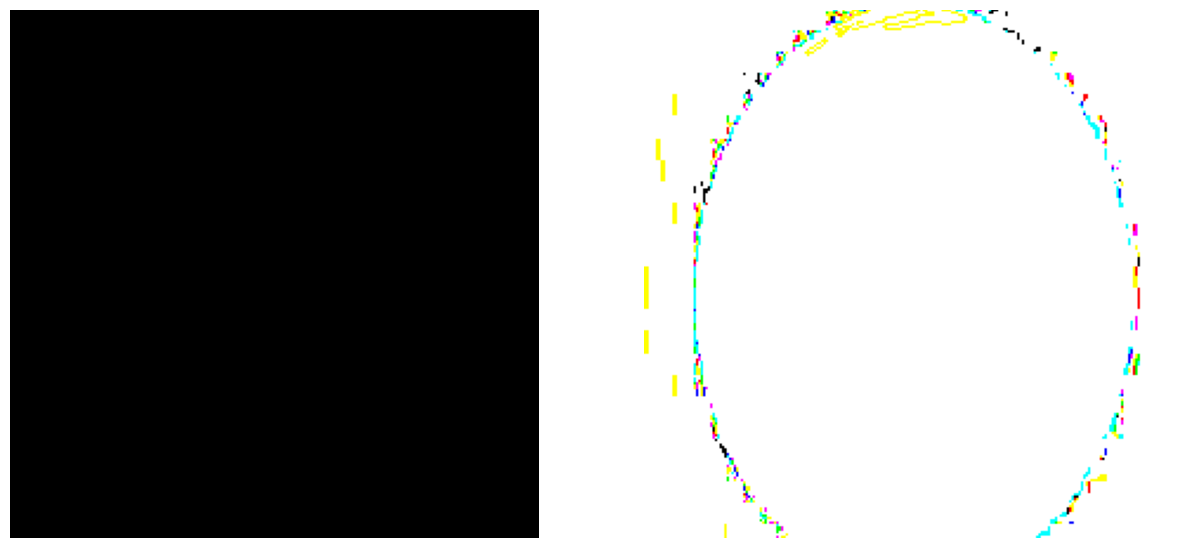

In [31]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')